Alternative data engineering options.

In [9]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

df = pd.read_csv(os.path.join(config['data_path'], 'full_kpis.csv'), index_col=0)
print(df.shape)
df.head()

(12741835, 10)


,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
timestamp,,,,,,,,,,
2023-09-01 02:30:00,154_0_1,154,0,1,-102.50,78.0,0.829355,17.457447,18.521277,0
2023-09-01 02:30:00,154_1_1,154,1,1,-103.84,159.0,1.450913,27.500000,29.200000,0
2023-09-01 02:30:00,154_2_1,154,2,1,-104.92,60.0,0.746502,4.558011,4.795580,0
2023-09-01 02:30:00,162_0_0,162,0,0,-104.19,43.0,0.436677,84.500000,88.785714,0
2023-09-01 02:30:00,162_0_1,162,0,1,-103.93,48.0,0.519392,90.785714,96.428571,0


In [6]:
# reset index
df = df.reset_index()

# Overalls

In [7]:
# Calculate overall KPIs for each cell
overall_kpis = df.groupby('cell').agg({
    'pageSessions': 'sum',
    'ULvol': 'sum',
    'sessionDur': 'sum',
    'blocks': 'sum'
}).reset_index()

# Rename columns
overall_kpis.rename(columns={
    'pageSessions': 'OverallPaging',
    'ULvol': 'OverallULvol',
    'sessionDur': 'OverallSessionDur',
    'blocks': 'OverallBlocks'
}, inplace=True)

# Merge overall KPIs with the original dataframe
df = df.merge(overall_kpis, on='cell')

In [8]:
print(df.shape)
df.head()

(12741835, 15)


,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks,OverallPaging,OverallULvol,OverallSessionDur,OverallBlocks
0,2023-09-01 02:30:00,154_0_1,154,0,1,-102.50,78.0,0.829355,17.457447,18.521277,0,1727210.0,19283.265391,492689.117807,168
1,2023-09-01 03:00:00,154_0_1,154,0,1,-103.00,134.0,1.719110,33.403226,35.153226,0,1727210.0,19283.265391,492689.117807,168
2,2023-09-01 03:30:00,154_0_1,154,0,1,-103.38,135.0,1.940300,38.572917,40.635417,0,1727210.0,19283.265391,492689.117807,168
3,2023-09-01 04:00:00,154_0_1,154,0,1,-103.76,148.0,1.782225,39.304348,41.489130,0,1727210.0,19283.265391,492689.117807,168
4,2023-09-01 04:30:00,154_0_1,154,0,1,-104.01,191.0,2.154401,43.637931,45.991379,0,1727210.0,19283.265391,492689.117807,168


## Visualization

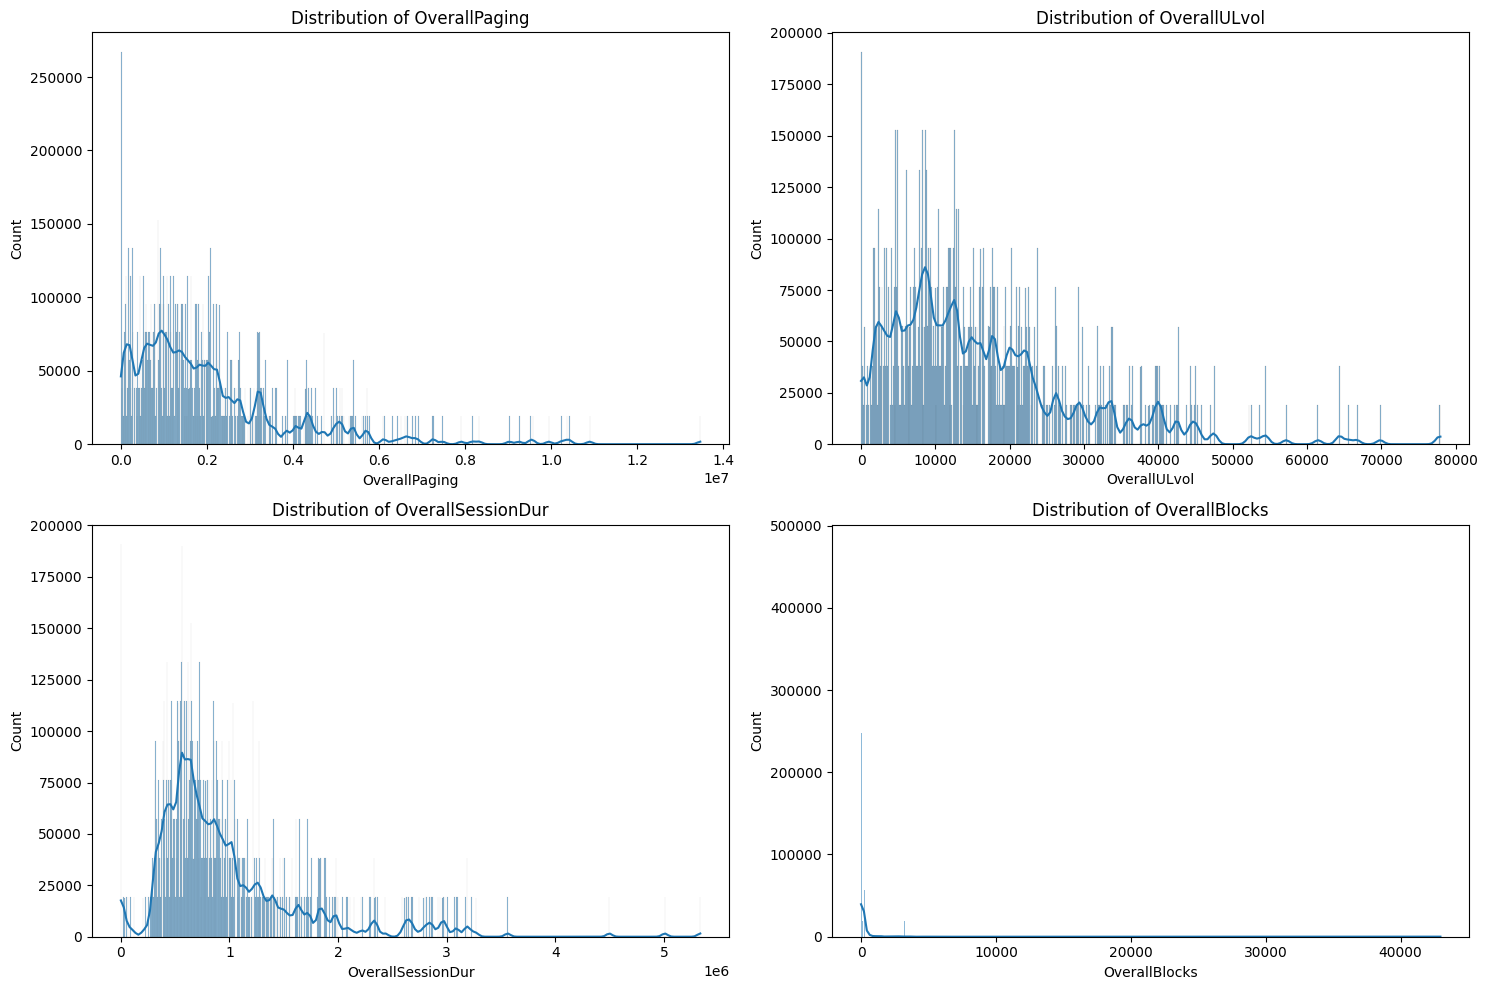

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot distribution for OverallPaging
plt.subplot(2, 2, 1)
sns.histplot(df['OverallPaging'], kde=True)
plt.title('Distribution of OverallPaging')

# Plot distribution for OverallULvol
plt.subplot(2, 2, 2)
sns.histplot(df['OverallULvol'], kde=True)
plt.title('Distribution of OverallULvol')

# Plot distribution for OverallSessionDur
plt.subplot(2, 2, 3)
sns.histplot(df['OverallSessionDur'], kde=True)
plt.title('Distribution of OverallSessionDur')

# Plot distribution for OverallBlocks
plt.subplot(2, 2, 4)
sns.histplot(df['OverallBlocks'], kde=True)
plt.title('Distribution of OverallBlocks')

plt.tight_layout()
plt.show()

# Neighbor KPIs

In [11]:
df.drop(columns=['sessionSetupDur'], inplace=True)

In [12]:
# print cells that have a unique value for bts, ie no neighbors
unique_cells = df['bts'].value_counts()[df['bts'].value_counts() == 1].index
print(f'Number of cells with unique bts: {len(unique_cells)}')

Number of cells with unique bts: 0


In [13]:
# Create new features that average the values of all 'neighbor cells' for a given cell at the same timestamp
kpis = ['minRSSI', 'pageSessions', 'ULvol', 'sessionDur', 'blocks']

for feature in kpis:
    df[f'nghb_{feature}'] = df.groupby(['bts', 'timestamp'])[feature].transform(
        lambda x: (x.sum() - x) / (len(x) - 1) if len(x) > 1 else np.nan
    )

# Display the first few rows of the dataframe to verify the new features
df.head()

,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionDur,blocks,OverallPaging,OverallULvol,OverallSessionDur,OverallBlocks,nghb_minRSSI,nghb_pageSessions,nghb_ULvol,nghb_sessionDur,nghb_blocks
0,2023-09-01 02:30:00,154_0_1,154,0,1,-102.50,78.0,0.829355,18.521277,0,1727210.0,19283.265391,492689.117807,168,-104.380,109.5,1.098707,16.997790,0.0
1,2023-09-01 03:00:00,154_0_1,154,0,1,-103.00,134.0,1.719110,35.153226,0,1727210.0,19283.265391,492689.117807,168,-104.025,225.0,2.029301,28.958569,0.0
2,2023-09-01 03:30:00,154_0_1,154,0,1,-103.38,135.0,1.940300,40.635417,0,1727210.0,19283.265391,492689.117807,168,-103.770,231.5,2.226361,30.057825,0.0
3,2023-09-01 04:00:00,154_0_1,154,0,1,-103.76,148.0,1.782225,41.489130,0,1727210.0,19283.265391,492689.117807,168,-104.465,237.5,2.370289,32.291904,0.0
4,2023-09-01 04:30:00,154_0_1,154,0,1,-104.01,191.0,2.154401,45.991379,0,1727210.0,19283.265391,492689.117807,168,-103.950,308.0,2.566768,31.402415,0.0


In [14]:
# Validate

# Shpw the original and new features for a sample cell at a sample timestamp
sample_bts = 180
feature = 'minRSSI'
sample_timestamp = '2024-10-02 20:00:00'

df[(df['bts'] == sample_bts) & (df['timestamp'] == sample_timestamp)]

,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionDur,blocks,OverallPaging,OverallULvol,OverallSessionDur,OverallBlocks,nghb_minRSSI,nghb_pageSessions,nghb_ULvol,nghb_sessionDur,nghb_blocks
761592,2024-10-02 20:00:00,180_0_0,180,0,0,-103.94,34.0,0.066082,20.645833,0,4660667.0,39851.219390,1.948683e+06,253,-103.336,52.6,0.524269,11.823863,0.0
780677,2024-10-02 20:00:00,180_0_1,180,0,1,-103.32,31.0,0.061604,6.660000,0,4721750.0,39604.953938,1.610679e+06,137,-103.460,53.2,0.525165,14.621030,0.0
799762,2024-10-02 20:00:00,180_1_0,180,1,0,-104.40,88.0,0.870980,13.294118,0,5730379.0,57173.675013,1.269329e+06,748,-103.244,41.8,0.363289,13.294206,0.0
818847,2024-10-02 20:00:00,180_1_1,180,1,1,-103.90,38.0,0.361540,12.916667,0,4441114.0,47558.803482,1.467441e+06,692,-103.344,51.8,0.465177,13.369697,0.0
837932,2024-10-02 20:00:00,180_2_0,180,2,0,-103.57,85.0,1.026226,10.504630,0,4081361.0,40375.926756,1.092348e+06,141,-103.410,42.4,0.332240,13.852104,0.0
857017,2024-10-02 20:00:00,180_2_1,180,2,1,-101.49,21.0,0.300995,15.743902,0,2995763.0,32393.588846,1.709628e+06,77,-103.826,55.2,0.477286,12.804249,0.0


## Export

In [15]:
df.to_csv(os.path.join(config['data_path'], 'full_eng.csv'), index=False)